In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

irf_attrs = {"ff_ex": {}, "ff_in": {}, "fb_ex": {}, "fb_in": {}}

## Feedforward excitation

In [2]:
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                        tau_rg=tau_rg, delay_rg=delay_rg)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
Nr = network.integrator.Nr
temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
t_peak, I_bp = temporal_irf_params(temporal_irf, network.integrator.times)

t_peak = float(t_peak.rescale("ms").magnitude)
I_bp = float(I_bp.magnitude)

irf_attrs["ff_ex"] = {"irf": temporal_irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedforward inhibition

In [3]:
t_peak = np.zeros([len(delay_rig), len(tau_rig)]) * pq.ms
I_bp = np.zeros([len(delay_rig), len(tau_rig)])
irf = np.zeros([2**nt, len(delay_rig), len(tau_rig)])

for i, delay in enumerate(delay_rig):
    for j, tau in enumerate(tau_rig):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau, delay_rig=delay)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["ff_in"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedback inhibition

In [4]:
t_peak = np.zeros([len(delay_rc_in), len(tau_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(tau_rc_in)])
irf = np.zeros([2**nt, len(delay_rc_in), len(tau_rc_in)])

for i, d in enumerate(delay_rc_in):
    for j, tau in enumerate(tau_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau, delay_rc_in=d)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["fb_in"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedback excitation

In [5]:
t_peak = np.zeros([len(delay_rc_ex), len(tau_rc_ex)]) * pq.ms
I_bp = np.zeros([len(delay_rc_ex), len(tau_rc_ex)])
irf = np.zeros([2**nt, len(delay_rc_ex), len(tau_rc_ex)])

for i, d in enumerate(delay_rc_ex):
    for j, tau in enumerate(tau_rc_ex):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau, delay_rc_ex=d)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["fb_ex"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

-------------
## Plotting

### Settings

In [6]:
cmap = "RdBu_r"
interpolation = "None"
color = "gray"
alpha = 0.6


# line plots:
t_max = 150
ymin = -0.4
ymax = 0.9
times = network.integrator.times
tau_ids = [0, int(len(tau_rc_in)/2 - 1), -1]

# imshow plots:
t_peak_vmin = 0.9
t_peak_vmax = 1.1
t_peak_levels = np.array([25, 40]) / irf_attrs["ff_ex"]["t_peak"]

I_bp_vmin = 0.5
I_bp_vmax = 2.0
I_bp_levels = np.array([0.2, 0.6]) / irf_attrs["ff_ex"]["I_bp"]



# figure grid
fig = plt.figure(figsize=(9, 10))

# line plots
gs1 = gridspec.GridSpec(6, 2)
gs1.update(left=0.05, right=0.45, hspace=5, wspace=0.05)

ax_1 = plt.subplot(gs1[:2, 0])
ax_2 = plt.subplot(gs1[:2, 1])
ax_5 = plt.subplot(gs1[2:4, 0])
ax_6 = plt.subplot(gs1[2:4, 1])
ax_9 = plt.subplot(gs1[4:6, 0])
ax_10 = plt.subplot(gs1[4:6, 1])

# imshow plots
gs2 = gridspec.GridSpec(6, 2)
gs2.update(left=0.55, right=0.98, hspace=5, wspace=0.15)

ax_3 = plt.subplot(gs2[:2, 0])
ax_4 = plt.subplot(gs2[:2, 1])
ax_7 = plt.subplot(gs2[2:4, 0])
ax_8 = plt.subplot(gs2[2:4, 1])
ax_11 = plt.subplot(gs2[4:6, 0])
ax_12 = plt.subplot(gs2[4:6, 1])


# labels, titles:
titles = ["Feedforward inhibition", "Inhibitory feedback", "Excitatory feedback"]

plt.figtext(0.5, 0.95, titles[0], ha='center', va='center', fontsize=18)
plt.figtext(0.5, 0.64, titles[1], ha='center', va='center', fontsize=18)
plt.figtext(0.5, 0.34, titles[2], ha='center', va='center', fontsize=18)

tau_labels = [r"$\tau_\mathrm{RIG}$", 
              r"$\tau_\mathrm{RCR}^\mathrm{in}$", 
              r"$\tau_\mathrm{RCR}^\mathrm{ex}$"]

delay_labels = [r"$\Delta_\mathrm{RIG}$", 
                r"$\Delta_\mathrm{RCR}^\mathrm{in}$", 
                r"$\Delta_\mathrm{RCR}^\mathrm{ex}$"]
extents = []
for delay, tau in zip([delay_rig, delay_rc_in, delay_rc_ex], 
                  [tau_rig, tau_rc_in, tau_rc_ex]):
    
    extent = [float(tau.min().magnitude), float(tau.max().magnitude), 
              float(delay.min().magnitude), float(delay.max().magnitude)]
    extents.append(extent)
    
plt.close()

### Create figure

In [7]:
for ax_row, irf_attr, delay, tau, tau_label, delay_label, extent in zip([[ax_1, ax_2, ax_3, ax_4],
                                                                         [ax_5, ax_6, ax_7, ax_8],
                                                                         [ax_9, ax_10, ax_11, ax_12]], 
                                                                        [irf_attrs["ff_in"], 
                                                                         irf_attrs["fb_in"], 
                                                                         irf_attrs["fb_ex"]],
                                                                        [delay_rig, delay_rc_in, delay_rc_ex],
                                                                        [tau_rig, tau_rc_in, tau_rc_ex],
                                                                        tau_labels, delay_labels, extents):
   
    ax1, ax2, ax3, ax4 = ax_row
    
    # line plots
    for ax, delay_id in zip([ax1, ax2], [0, -1]):
        ax.plot(times, irf_attrs["ff_ex"]["irf"], color='k', linestyle="--")
        ax.set_ylim([ymin, ymax])
        ax.set_xlim([0, t_max])
        delay_magnitude = round(float(delay[delay_id].magnitude), 1)
        ax.set_title(delay_label+r"${{=}}{}\mathrm{{ms}}$".format(delay_magnitude))
        
        for tau_id in tau_ids:
            tau_magnitude = round(float(tau[tau_id].magnitude), 1) 
            ax.plot(times, irf_attr["irf"][:, delay_id, tau_id],
                    label=tau_label+r"${{=}}{}\mathrm{{ms}}$".format(tau_magnitude))
    
    ax1.legend(fontsize=14, handlelength=0.3, labelspacing=0.2, borderpad=0.0, 
             borderaxespad=0.1, handletextpad=0.05)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if not ax1 == ax_9:
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    
    # t_peak plot
    t_peak = irf_attr["t_peak"].rescale("ms") / irf_attrs["ff_ex"]["t_peak"]
    im1 = ax3.imshow(t_peak, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=t_peak_vmin, vmax=t_peak_vmax, 
                     norm=MidpointNormalize(midpoint=1.))

    t_peak_mask = np.where((t_peak >= t_peak_levels[0]) & (t_peak <= t_peak_levels[-1]), 0, 1)
    ax3.contourf(t_peak_mask, extent=extent, levels=t_peak_levels, colors=color, alpha=alpha)
    
    plt.colorbar(im1, ax=ax3, ticks=[t_peak_vmin, 1, t_peak_vmax])
    ax3.grid(False)  
    ax3.set_ylabel(delay_label)
    ax3.set_xlabel(tau_label)

    
    # Biphasic index plot
    I_bp = irf_attr["I_bp"] / irf_attrs["ff_ex"]["I_bp"]
    im2 = ax4.imshow(I_bp, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=I_bp_vmin, vmax=I_bp_vmax, 
                     norm=MidpointNormalize(midpoint=1.))

    I_bp_mask = np.where((I_bp  >= I_bp_levels[0]) & (I_bp  <= I_bp_levels[-1]), 0, 1)
    ax4.contourf(I_bp_mask, extent=extent, levels=I_bp_levels, colors=color, alpha=alpha)
    
    plt.colorbar(im2, ax=ax4, ticks=[I_bp_vmin, 1, I_bp_vmax])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.grid(False)
    
ax_3.set_title(r"$t_\mathrm{peak}$")
ax_4.set_title("Biphasic index")
ax_9.set_xlabel("Time (ms)")
ax_9.set_ylabel("Response")

plt.close()


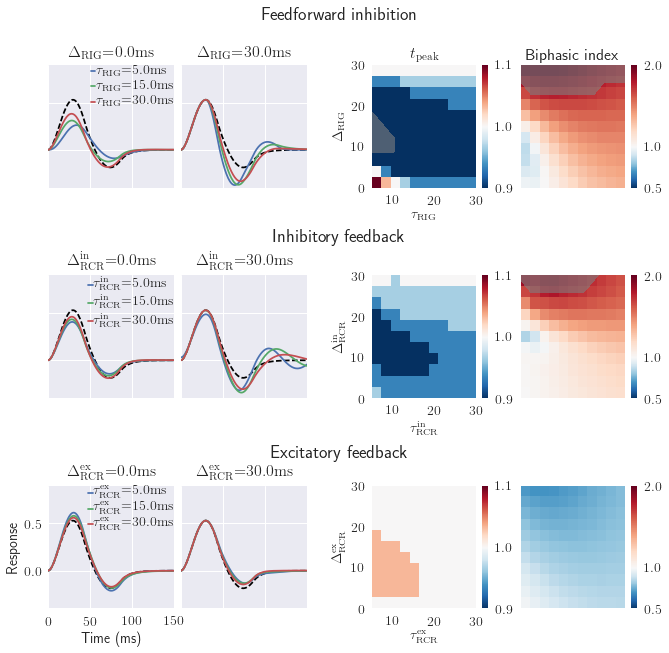

In [8]:
fig